In [5]:
coins_to_train = ['EOS','TRX','ADA','SOL']

In [6]:
from tensortrade.data.cdd import CryptoDataDownload
import pandas as pd
import numpy as np
import ta
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None
import pywt
from statsmodels.robust import mad
import numpy as np

def prepare_data(data, coin):
    """ cylicial feature encoding following: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca"""  
    data['dayOfWeek'] = data['%s:date' %coin].dt.dayofweek
    dataDayOfWeekMax = data['dayOfWeek'].max()
    data['%s:dayOfWeek_sin' % coin] = np.sin(2 * np.pi * data['dayOfWeek']/dataDayOfWeekMax)
    data['%s:dayOfWeek_cos' % coin] = np.cos(2 * np.pi * data['dayOfWeek']/dataDayOfWeekMax)
    """ Date cos & sin """
    data['dayInYear'] = data['%s:date' % coin].apply(lambda x: int(x.strftime('%j')))
    dataDayInYearMax = data['dayInYear'].max()
    data['%s:dayInYear_sin' % coin] = np.sin(2 * np.pi * data['dayInYear']/dataDayInYearMax)
    data['%s:dayInYear_cos' % coin] = np.cos(2 * np.pi * data['dayInYear']/dataDayInYearMax)
    """ Time cos & sin """
    data["timeOfDay"] = (data['%s:date' % coin].dt.hour*60) + data['%s:date' % coin].dt.minute
    dataTimeOfDayMax = data['timeOfDay'].max()
    data['%s:timeOfDay_sin' % coin] = np.sin(2 * np.pi * data['timeOfDay']/dataTimeOfDayMax)
    data['%s:timeOfDay_cos' % coin] = np.cos(2 * np.pi * data['timeOfDay']/dataTimeOfDayMax)
    """ Month cos & sin """
    data["monthInYear"] = data['%s:date' % coin].dt.month
    dataMonthInYearMax = data['monthInYear'].max()
    data['%s:monthInYear_sin' % coin] = np.sin(2 * np.pi * data['monthInYear']/dataMonthInYearMax)
    data['%s:monthInYear_cos'% coin] = np.cos(2 * np.pi * data['monthInYear']/dataMonthInYearMax)
   
    data = data.set_index('%s:date' % coin)
    
    #normalize the data over MA
    data['%s:close_ma_20' % coin] = ta.trend.ema_indicator(data['%s:close' % coin], window=20, fillna=True)
    data['%s:closing_smooth' % coin] = (data['%s:close' % coin] - data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin] 
    data['%s:open_smooth' % coin] = (data['%s:open' % coin] - data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin]
    data['%s:high_smooth' % coin] = (data['%s:high' % coin] - data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin]
    data['%s:low_smooth' % coin] = (data['%s:low' % coin] -data['%s:close_ma_20' % coin]) / data['%s:close_ma_20' % coin]
    data['%s:volume_ma_20' % coin] = ta.trend.ema_indicator(data['%s:volume' % coin], window=20, fillna=True)
    data['%s:volume_smooth' % coin] = (data['%s:volume' % coin] - data['%s:volume_ma_20' % coin]) / data['%s:volume_ma_20' % coin]
   
    columns_to_drop = ['timeOfDay', 'dayOfWeek',  'monthInYear', 'dayInYear', \
                       ('%s:tradecount' % coin),('%s:unix' % coin), \
                       ('%s:open' % coin), ('%s:close' % coin), ('%s:high' % coin), ('%s:low' % coin), ('%s:volume' % coin), \
                      ('%s:close_ma_20' % coin), ('%s:volume_ma_20' % coin)]
    data = data.drop(columns_to_drop, axis=1)

    return data

def fetch_data(coins=['EOS'], candles="1h"):
    cdd = CryptoDataDownload()
    binance_data = pd.DataFrame()
    for coin in coins:
        coin_data = cdd.fetch("Binance", "USDT", coin, candles).add_prefix("%s:" % coin)
        coin_data = prepare_data(coin_data[coin_data['%s:date' % coin] >= pd.to_datetime('2020-01-01 00:00:00')],coin)
        binance_data = pd.concat((binance_data,coin_data), axis=1)
    return binance_data

data = fetch_data(coins_to_train, "1h")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Plot cylicial features 

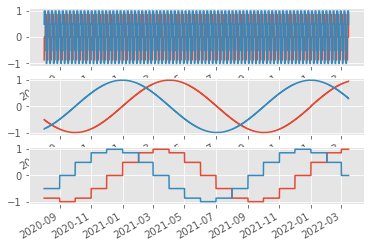

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1)                  
data['EOS:dayOfWeek_sin'].dropna().plot(ax=axes[0])
data['EOS:dayOfWeek_cos'].dropna().plot(ax=axes[0])
data['EOS:dayInYear_sin'].dropna().plot(ax=axes[1])
data['EOS:dayInYear_cos'].dropna().plot(ax=axes[1])
data['EOS:monthInYear_sin'].dropna().plot(ax=axes[2])
data['EOS:monthInYear_cos'].dropna().plot(ax=axes[2])

# Split Data

In [8]:
# 8736 is roughly 1 year of hour candles
num_datapoints = data.shape[0]
# roll by approx. 60 days - 3 months of trading days
step_size = int(0.1 * num_datapoints)


test = data[-step_size:]
validate = data[-2*step_size:-step_size]
train = data[:-2*step_size]

print(test.shape)
print(validate.shape)
print(train.shape)
print(train.index.min())
print(train.index.max())
print(validate.index.min())
print(validate.index.max())
print(test.index.min())
print(test.index.max())

(1414, 52)
(1414, 52)
(11316, 52)
2020-08-01 23:00:00
2021-11-17 04:00:00
2021-11-17 05:00:00
2022-01-15 02:00:00
2022-01-15 03:00:00
2022-03-15 00:00:00


# Normalize

### Create Training Set and Z-Score Transform

In [9]:
normalize_columns = train.filter(regex='closing|low|high|open|volume').columns

In [10]:
data_header = ['open','closing','high','low','volume']
train_normalized = train.copy()
# Calculate mean across coins per OHCLV data
for header in data_header:
    header_to_normalize = train.filter(regex=header).columns
    train_normalized_temp = train_normalized[header_to_normalize]
    train_list = pd.concat((train_normalized_temp.iloc[:,0] , train_normalized_temp.iloc[:,1] , train_normalized_temp.iloc[:,2] , train_normalized_temp.iloc[:,3]), axis=0)
    mean = np.mean(train_list.dropna())
    std = np.std(train_list.dropna())
    for i in header_to_normalize:
        train_normalized[i] = (train_normalized[i] - mean)  / (3 * std)

## Validation Data

### Create Validation Set and Z-Score Transform

In [11]:
from statistics import mean
data_header = ['closing','low','high','open','volume']
train = train_normalized.copy()
validate_normalized = pd.DataFrame()
for header in data_header:
    header_to_normalize = train.filter(regex=header).columns
    temp = train[header_to_normalize]
    validate_normalized_temp = validate[header_to_normalize]
    for j in range(validate.shape[0]):
        list_datapoints = []
        temp = np.append(temp, np.expand_dims(validate_normalized_temp.iloc[j,:], axis=0), axis=0)
        for coin in range(len(coins_to_train)):
            list_datapoints.extend(temp[:,coin])
        for i in range(validate_normalized_temp.shape[1]):
            index_row = temp.shape[0] - 1
            mean = np.nanmean(list_datapoints)
            std = np.nanstd(list_datapoints)
            validate_normalized.loc[j,header_to_normalize[i]] = (temp[index_row,i] - mean)  / (3 * std)
            
validate.reset_index(inplace=True)
validate = validate.drop(normalize_columns, axis=1)
validate_normalized = pd.concat((validate,validate_normalized),axis=1)
validate_normalized.set_index('index')

,EOS:dayOfWeek_sin,EOS:dayOfWeek_cos,EOS:dayInYear_sin,EOS:dayInYear_cos,EOS:timeOfDay_sin,EOS:timeOfDay_cos,EOS:monthInYear_sin,EOS:monthInYear_cos,TRX:dayOfWeek_sin,TRX:dayOfWeek_cos,...,ADA:high_smooth,SOL:high_smooth,EOS:open_smooth,TRX:open_smooth,ADA:open_smooth,SOL:open_smooth,EOS:volume_smooth,TRX:volume_smooth,ADA:volume_smooth,SOL:volume_smooth
index,,,,,,,,,,,,,,,,,,,,,
2021-11-17 05:00:00,0.866025,-0.5,-0.697944,0.716152,9.790841e-01,0.203456,-0.5,0.866025,0.866025,-0.5,...,-0.016349,-0.025331,-0.017194,-0.018298,-0.028565,-0.031317,-0.193125,-0.207336,-0.170478,-0.025246
2021-11-17 06:00:00,0.866025,-0.5,-0.697944,0.716152,9.976688e-01,-0.068242,-0.5,0.866025,0.866025,-0.5,...,-0.016195,-0.022459,-0.013487,-0.012792,-0.016726,-0.025416,-0.356453,-0.202779,-0.014321,-0.282428
2021-11-17 07:00:00,0.866025,-0.5,-0.697944,0.716152,9.422609e-01,-0.334880,-0.5,0.866025,0.866025,-0.5,...,-0.005660,-0.012428,-0.016711,-0.011646,-0.021121,-0.030350,0.247376,-0.151629,0.037679,-0.114479
2021-11-17 08:00:00,0.866025,-0.5,-0.697944,0.716152,8.169699e-01,-0.576680,-0.5,0.866025,0.866025,-0.5,...,-0.005309,-0.007579,-0.009802,-0.003645,-0.012786,-0.018497,-0.352402,-0.018500,-0.094566,-0.183716
2021-11-17 09:00:00,0.866025,-0.5,-0.697944,0.716152,6.310879e-01,-0.775711,-0.5,0.866025,0.866025,-0.5,...,-0.014877,-0.014278,-0.009074,-0.003292,-0.015409,-0.014320,-0.309748,-0.077693,0.749530,-0.046468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-14 22:00:00,-0.866025,-0.5,0.238033,0.971257,-2.697968e-01,0.962917,0.5,0.866025,-0.866025,-0.5,...,0.033928,0.003530,0.009895,0.008976,0.028115,0.000909,-0.562930,-0.307429,0.209870,-0.474204
2022-01-14 23:00:00,-0.866025,-0.5,0.238033,0.971257,-2.449294e-16,1.000000,0.5,0.866025,-0.866025,-0.5,...,0.019979,0.002838,0.009468,0.006636,0.014179,0.000725,-0.316191,-0.035856,-0.311903,-0.392003
2022-01-15 00:00:00,-0.866025,0.5,0.254671,0.967028,0.000000e+00,1.000000,0.5,0.866025,-0.866025,0.5,...,0.019646,-0.002498,-0.000266,0.002467,0.019750,-0.003957,-0.177098,-0.118964,-0.096277,-0.424016


## Test Data

### Create Test Set and Z_Score Transform

In [12]:
from statistics import mean
data_header = ['closing','low','high','open','volume']
temp_train = train_normalized.copy().filter(regex='closing|low|high|open|volume')
temp_val = validate_normalized.copy().filter(regex='closing|low|high|open|volume')
train_val = pd.concat((temp_train, temp_val),axis=0)
test_normalized = pd.DataFrame()
for header in data_header:
    header_to_normalize = train.filter(regex=header).columns
    temp = train_val[header_to_normalize]
    test_normalized_temp = test[header_to_normalize]
    for j in range(test.shape[0]):
        list_datapoints = []
        temp = np.append(temp, np.expand_dims(test_normalized_temp.iloc[j,:], axis=0), axis=0)
        for coin in range(len(coins_to_train)):
            list_datapoints.extend(temp[:,coin])
        for i in range(test_normalized_temp.shape[1]):
            index_row = temp.shape[0] - 1
            mean = np.nanmean(list_datapoints)
            std = np.nanstd(list_datapoints)
            test_normalized.loc[j,header_to_normalize[i]] = (temp[index_row,i] - mean)  / (3 * std)
test.reset_index(inplace=True)
test = test.drop(normalize_columns, axis=1)
test_normalized = pd.concat((test,test_normalized),axis=1)
test_normalized.set_index('index')

,EOS:dayOfWeek_sin,EOS:dayOfWeek_cos,EOS:dayInYear_sin,EOS:dayInYear_cos,EOS:timeOfDay_sin,EOS:timeOfDay_cos,EOS:monthInYear_sin,EOS:monthInYear_cos,TRX:dayOfWeek_sin,TRX:dayOfWeek_cos,...,ADA:high_smooth,SOL:high_smooth,EOS:open_smooth,TRX:open_smooth,ADA:open_smooth,SOL:open_smooth,EOS:volume_smooth,TRX:volume_smooth,ADA:volume_smooth,SOL:volume_smooth
index,,,,,,,,,,,,,,,,,,,,,
2022-01-15 03:00:00,-0.866025,0.5,0.254671,0.967028,7.308360e-01,0.682553,0.5,8.660254e-01,-0.866025,0.5,...,0.003128,0.002460,0.004229,0.005432,0.001511,0.003005,-0.220393,-0.279866,-0.635339,-0.430766
2022-01-15 04:00:00,-0.866025,0.5,0.254671,0.967028,8.878852e-01,0.460065,0.5,8.660254e-01,-0.866025,0.5,...,-0.000312,-0.002464,0.000285,0.004726,-0.000245,-0.003818,-0.334391,0.259293,-0.448815,-0.169129
2022-01-15 05:00:00,-0.866025,0.5,0.254671,0.967028,9.790841e-01,0.203456,0.5,8.660254e-01,-0.866025,0.5,...,0.002874,-0.004721,-0.001364,0.005159,-0.007171,-0.008854,-0.472681,-0.228191,-0.573007,-0.319183
2022-01-15 06:00:00,-0.866025,0.5,0.254671,0.967028,9.976688e-01,-0.068242,0.5,8.660254e-01,-0.866025,0.5,...,0.001182,-0.005637,-0.002214,0.002967,0.001250,-0.008237,-0.235877,-0.201797,-0.374203,-0.401488
2022-01-15 07:00:00,-0.866025,0.5,0.254671,0.967028,9.422609e-01,-0.334880,0.5,8.660254e-01,-0.866025,0.5,...,0.001015,-0.003450,0.003165,0.005092,0.000241,-0.004295,1.690383,-0.158850,-0.456175,-0.516190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-14 20:00:00,0.000000,1.0,0.949990,0.312281,-7.308360e-01,0.682553,1.0,6.123234e-17,0.000000,1.0,...,-0.001458,-0.001934,-0.007983,-0.000986,-0.005392,-0.003560,-0.418841,-0.369053,-0.379521,-0.432929
2022-03-14 21:00:00,0.000000,1.0,0.949990,0.312281,-5.195840e-01,0.854419,1.0,6.123234e-17,0.000000,1.0,...,0.003124,-0.003058,-0.009870,-0.003134,-0.003664,-0.011480,-0.176928,-0.406103,-0.497430,-0.434699
2022-03-14 22:00:00,0.000000,1.0,0.949990,0.312281,-2.697968e-01,0.962917,1.0,6.123234e-17,0.000000,1.0,...,0.018265,0.015550,-0.010313,-0.002665,-0.004203,-0.005596,0.896562,0.279605,0.627339,0.567018


### Plot 

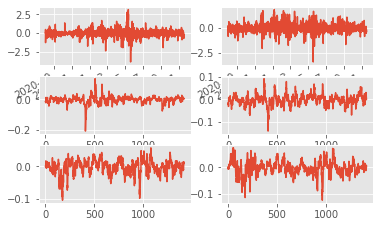

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2)                  
train_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[0,0])
train_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[0,1])
validate_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[1,0])
validate_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[1,1])
test_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[2,0])
test_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[2,1])

### Export

In [14]:
import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
validate_csv = os.path.join(cwd, 'validate.csv')
test_csv = os.path.join(cwd, 'test.csv')
train_normalized.to_csv(train_csv, index=True)
validate_normalized.to_csv(validate_csv, index=True)
test_normalized.to_csv(test_csv, index=True)

## Wavelets

In [15]:
def waveletSmooth( x, wavelet="haar", level=2, declevel=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode='periodization',level=declevel,axis=0 )
    # calculate a threshold
    sigma = mad(coeff[-level])
    #print("sigma: ",sigma)
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    #print("uthresh: ", uthresh)
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="hard" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode='periodization',axis=0 )
    return y

### Create Training Set and Wavelet Transform

In [16]:
train_normalized = train.copy()
for i in normalize_columns:
    train_normalized[i] = waveletSmooth(train_normalized[i], level=1)[-len(train):]

### Create Validation Set and Wavelet Transform

In [17]:
temp = train_normalized.copy().filter(regex='closing|low|high|open|volume')
feats_norm_validate_WT = validate_normalized.copy().filter(regex='closing|low|high|open|volume')
for j in range(validate_normalized.shape[0]):
    temp = np.append(temp, np.expand_dims(feats_norm_validate_WT.iloc[j,:], axis=0), axis=0)
    for i in range(feats_norm_validate_WT.shape[1]):
        feats_norm_validate_WT.iloc[j,i] = waveletSmooth(temp[:,i], level=1)[-1]
      

In [18]:
validate_normalized.reset_index(inplace=True)
validate_normalized = validate_normalized.drop(normalize_columns, axis=1)
validate_normalized_wavelet = pd.concat((validate_normalized,feats_norm_validate_WT),axis=1)
validate_normalized_wavelet = validate_normalized_wavelet.drop('level_0', axis=1)
validate_normalized_wavelet = validate_normalized_wavelet.set_index('index')

### Create Test Set and Wavelet Transform

In [19]:
temp_train = train_normalized.copy().filter(regex='closing|low|high|open|volume')
temp_val = validate_normalized.copy().filter(regex='closing|low|high|open|volume')
temp = pd.concat((temp_train, temp_val),axis=0)
feats_norm_test_WT = test_normalized.copy().filter(regex='closing|low|high|open|volume')
for j in range(test_normalized.shape[0]):
   #first concatenate train with the latest validation sample
    temp = np.append(temp, np.expand_dims(feats_norm_test_WT.iloc[j,:], axis=0), axis=0)
    for i in range(feats_norm_test_WT.shape[1]):
        feats_norm_test_WT.iloc[j,i] = waveletSmooth(temp[:,i], level=1)[-1]

In [20]:
test_normalized.reset_index(inplace=True)
test_normalized = test_normalized.drop(normalize_columns, axis=1)
test_normalized_wavelet = pd.concat((test_normalized,feats_norm_test_WT),axis=1)
test_normalized_wavelet = test_normalized_wavelet = test_normalized_wavelet.drop('level_0', axis=1)
test_normalized_wavelet = test_normalized_wavelet.set_index('index')

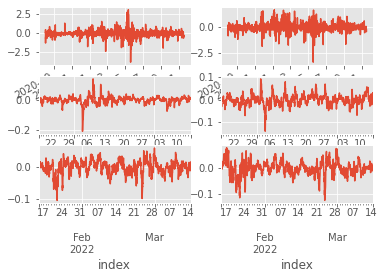

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2)                  
train_normalized['EOS:closing_smooth'].dropna().plot(ax=axes[0,0])
train_normalized['ADA:closing_smooth'].dropna().plot(ax=axes[0,1])
validate_normalized_wavelet['EOS:closing_smooth'].dropna().plot(ax=axes[1,0])
validate_normalized_wavelet['ADA:closing_smooth'].dropna().plot(ax=axes[1,1])
test_normalized_wavelet['EOS:closing_smooth'].dropna().plot(ax=axes[2,0])
test_normalized_wavelet['ADA:closing_smooth'].dropna().plot(ax=axes[2,1])

In [22]:
import os
cwd = os.getcwd()
train_wavelet_csv = os.path.join(cwd, 'train_wavelet.csv')
validate_wavelet_csv = os.path.join(cwd, 'validate_wavelet.csv')
test_wavelet_csv = os.path.join(cwd, 'test_wavelet.csv')

train_normalized.to_csv(train_wavelet_csv, index=True)
validate_normalized_wavelet.to_csv(validate_wavelet_csv, index=True)
test_normalized_wavelet.to_csv(test_wavelet_csv, index=True)

(array([5.17203377e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.17203377e-04, 2.06881351e-03, 3.10322026e-03, 6.72364390e-03,
        5.68923715e-03, 1.03440675e-02, 2.17225418e-02, 5.43063546e-02,
        9.61998281e-02, 2.60153299e-01, 7.15292270e-01, 1.90330843e+00,
        1.57643589e+00, 6.05127951e-01, 2.68945756e-01, 1.55678216e-01,
        6.82708458e-02, 5.74095748e-02, 2.48257621e-02, 8.27525403e-03,
        3.62042364e-03, 4.13762702e-03]),
 array([-3.41697720e+00, -3.24611511e+00, -3.07525302e+00, -2.90439093e+00,
        -2.73352884e+00, -2.56266676e+00, -2.39180467e+00, -2.22094258e+00,
        -2.05008049e+00, -1.87921840e+00, -1.70835632e+00, -1.53749423e+00,
        -1.36663214e+00, -1.19577005e+00, -1.02490796e+00, -8.54045876e-01,
        -6.83183788e-01, -5.12321700e-01, -3.41459612e-01, -1.70597524e-01,
         2.64563986e-04,  1.71126652e-01,  3.41988740e-01,  5.12850828e-01

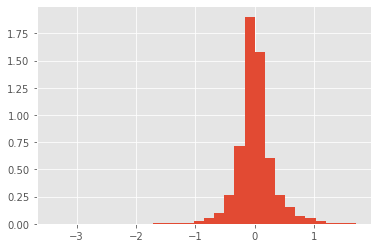

In [23]:
plt.hist(train_normalized['ADA:closing_smooth'], density=True, bins=30) 
#plt.hist(validate_normalized_wavelet['ADA:closing_smooth'], density=True, bins=30) 
#plt.hist(test_normalized_wavelet['ADA:closing_smooth'], density=True, bins=30) 

In [24]:
data = pd.DataFrame()
for coin in coins_to_train:
  headers = train_normalized.filter(regex=coin).columns
  temp = train_normalized[headers]
  temp.columns = temp.columns.str[4:]
  temp['ticker'] = coin
  temp = temp.rename(columns={'closing_smooth': 'close', 
                              'open_smooth': 'open',
                              'high_smooth': 'high',
                              'low_smooth': 'low',
                              'volume_smooth': 'volume'})
  data = pd.concat((data,temp), axis=0)
  data.dropna(how="any",inplace=True)
  


training_data_final = data.sort_index()
temp_encoder = pd.get_dummies(training_data_final['ticker'])
training_data_final = pd.concat((training_data_final,temp_encoder), axis=1)
training_data_final = training_data_final.reset_index()
training_data_final.index = training_data_final['index'].factorize()[0]
training_data_final = training_data_final.drop(['index', 'ticker'], axis=1)
cwd = os.getcwd()
train_done_csv = os.path.join(cwd, 'train_done.csv')
training_data_final.to_csv(train_done_csv, index=True)

In [25]:
data = pd.DataFrame()
for coin in coins_to_train:
  headers = validate_normalized_wavelet.filter(regex=coin).columns
  temp = validate_normalized_wavelet[headers]
  temp.columns = temp.columns.str[4:]
  temp['ticker'] = coin
  temp = temp.rename(columns={'closing_smooth': 'close', 
                              'open_smooth': 'open',
                              'high_smooth': 'high',
                              'low_smooth': 'low',
                              'volume_smooth': 'volume'})
  data = pd.concat((data,temp), axis=0)
  data.dropna(how="any",inplace=True)
  


validate_data_final = data.sort_index()
temp_encoder = pd.get_dummies(validate_data_final['ticker'])
validate_data_final = pd.concat((validate_data_final,temp_encoder), axis=1)
validate_data_final = validate_data_final.reset_index()
validate_data_final.index = validate_data_final['index'].factorize()[0]
validate_data_final = validate_data_final.drop(['index', 'ticker'], axis=1)
cwd = os.getcwd()
train_done_csv = os.path.join(cwd, 'validate_done.csv')
validate_data_final.to_csv(train_done_csv, index=True)

In [26]:
data = pd.DataFrame()
for coin in coins_to_train:
  headers = test_normalized_wavelet.filter(regex=coin).columns
  temp = test_normalized_wavelet[headers]
  temp.columns = temp.columns.str[4:]
  temp['ticker'] = coin
  temp = temp.rename(columns={'closing_smooth': 'close', 
                              'open_smooth': 'open',
                              'high_smooth': 'high',
                              'low_smooth': 'low',
                              'volume_smooth': 'volume'})
  data = pd.concat((data,temp), axis=0)
  data.dropna(how="any",inplace=True)
  


test_data_final = data.sort_index()
temp_encoder = pd.get_dummies(test_data_final['ticker'])
test_data_final = pd.concat((test_data_final,temp_encoder), axis=1)
test_data_final = test_data_final.reset_index()
test_data_final.index = test_data_final['index'].factorize()[0]
test_data_final = test_data_final.drop(['index', 'ticker'], axis=1)
cwd = os.getcwd()
test_done_csv = os.path.join(cwd, 'test_done.csv')
test_data_final.to_csv(test_done_csv, index=True)

In [27]:
test_data_final

,dayOfWeek_sin,dayOfWeek_cos,dayInYear_sin,dayInYear_cos,timeOfDay_sin,timeOfDay_cos,monthInYear_sin,monthInYear_cos,close,low,high,open,volume,ADA,EOS,SOL,TRX
0,-0.866025,0.5,0.254671,0.967028,9.790841e-01,0.203456,0.5,8.660254e-01,-0.001705,-0.004483,-0.001153,-0.001364,-0.472681,0,1,0,0
0,-0.866025,0.5,0.254671,0.967028,9.790841e-01,0.203456,0.5,8.660254e-01,0.002131,-0.007022,0.002874,-0.007171,-0.573007,1,0,0,0
0,-0.866025,0.5,0.255353,0.966848,9.790841e-01,0.203456,0.5,8.660254e-01,-0.008749,-0.008374,-0.004721,-0.008854,-0.319183,0,0,1,0
0,-0.866025,0.5,0.254671,0.967028,9.790841e-01,0.203456,0.5,8.660254e-01,0.003767,0.001879,0.004565,0.005159,-0.228191,0,0,0,1
1,-0.866025,0.5,0.254671,0.967028,9.976688e-01,-0.068242,0.5,8.660254e-01,0.004913,-0.003837,0.004344,-0.002214,-0.235877,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,0.000000,1.0,0.949990,0.312281,-2.449294e-16,1.000000,1.0,6.123234e-17,0.014041,0.005393,0.013962,0.003475,-0.113694,0,1,0,0
1411,0.866025,0.5,0.955211,0.295927,0.000000e+00,1.000000,1.0,6.123234e-17,-0.000676,0.001185,0.004126,0.003624,-0.264956,0,0,0,1
1411,0.866025,0.5,0.955211,0.295927,0.000000e+00,1.000000,1.0,6.123234e-17,0.008539,0.008649,0.014876,0.013148,-0.435301,0,1,0,0
1411,0.866025,0.5,0.955211,0.295927,0.000000e+00,1.000000,1.0,6.123234e-17,0.002077,0.002512,0.013068,0.009142,-0.377858,1,0,0,0
